In [ ]:
import lsdb
print(lsdb.__version__)
import hats
print(hats.__version__)
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.distributed import Client
from nested_pandas import NestedDtype

import nested_pandas as npd

In [ ]:
comcam_x_milliquas_computed.to_parquet("/sdf/home/n/ncaplar/AGN/comcam_x_milliquas_computed.parquet") # The output file path


In [ ]:
comcam_x_milliquas_computed = npd.read_parquet("/sdf/home/n/ncaplar/AGN/comcam_x_milliquas_computed.parquet") # The input file path

In [ ]:
comcam_x_milliquas_computed

In [ ]:
COLORS = {'u': '#0c71ff',
 'g': '#49be61',
 'r': '#c61c00',
 'i': '#ffc200',
 'z': '#f341a2',
 'y': '#5d0000'}

def create_mag_errors(flux, flux_err):
    # Make sure everything is valid and flux ± err stays positive
    upper = flux + flux_err
    lower = flux - flux_err
    mask = (
        flux.notna()
        & flux_err.notna()
        & (flux > 0)
        & (upper > 0)
        & (lower > 0)
    )

    # Initialize with NaNs
    mag = np.full_like(flux, np.nan, dtype=float)
    mag_err = np.full_like(flux, np.nan, dtype=float)

    # Apply the AB mag conversion only to valid values
    valid_flux = flux[mask]
    valid_err = flux_err[mask]

    mag[mask] = u.nJy.to(u.ABmag, valid_flux)
    upper_mag = u.nJy.to(u.ABmag, valid_flux + valid_err)
    lower_mag = u.nJy.to(u.ABmag, valid_flux - valid_err)
    mag_err[mask] = -(upper_mag - lower_mag) / 2

    return pd.Series(mag, index=flux.index), pd.Series(mag_err, index=flux.index)

def plot_mag_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    mag_vals = []
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        if band_lc.empty:
            continue
        mag, mag_err = create_mag_errors(band_lc[flux_col], band_lc[flux_err_col])
        ax.errorbar(
            band_lc[x_name],
            mag,
            mag_err,
            fmt="o",
            label=band,
            color=color,
            alpha=1,
            markersize=5,
            capsize=3,
            elinewidth=1,
        )
        mag_vals.extend(mag.dropna().values)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude (AB)")
    ax.invert_yaxis()
    if show_legend:
        ax.legend(loc="lower right", fontsize=12)
    return mag_vals

def scale_mag_y_axis(ax, all_mags):
    if all_mags[0]:
        ymin, ymax = np.nanmin(all_mags[0]), np.nanmax(all_mags[0])
        for i in range(2):
            ax[0, i].set_ylim(ymax + 0.1, ymin - 0.1)

"""            
def scale_mag_y_axis(ax, all_mags):
    if all_mags[0]:
        # Flatten, drop NaNs, compute median
        mags = np.array(all_mags[0])
        mags = mags[np.isfinite(mags)]
        if len(mags) > 0:
            median_mag = np.median(mags)
            for i in range(2):
                ax[0, i].set_ylim(median_mag + 0.5, median_mag - 0.5)
"""
def plot_mag_lightcurves(ax, row):
    datasets = [
        ("scienceFlux", "DIA Source", row.diaSource_COM),
        ("psfFlux", "DIA Forced", row.diaObjectForcedSource_COM),
    ]
    all_mags = [[], []]
    for i, (flux_col, label, lc) in enumerate(datasets):
        flux_err_col = f"{flux_col}Err"
        ax[0, i].set_title(f"{flux_col} ({label})")

        all_mags[0].extend(
            plot_mag_scale(ax[0, i], lc, flux_col, flux_err_col, "midpointMjdTai", "MJD", show_legend=(i == 1))
        )
    return all_mags

# Now plot
for i in range(len(comcam_AGN_many_r)):
    row = comcam_AGN_many_r.iloc[i]
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))  # Just one row now
    fig.suptitle(f"RA={row.ra_COM:.5f}, Dec={row.dec_COM:.5f}", fontsize=16)
    all_mags = plot_mag_lightcurves(np.expand_dims(ax, 0), row)  # Make ax 2D for consistency
    scale_mag_y_axis(np.expand_dims(ax, 0), all_mags)
    plt.tight_layout()
    plt.show()

In [ ]:

def calcSF(tclip, fclip, nbins=10):
    """
    Compute the structure function (SF) using bins with equal number of time-lagged pairs.

    Parameters
    ----------
    tclip : ndarray
        1D array of time values (sorted).
    fclip : ndarray
        1D array of flux or magnitude values.
    nbins : int
        Number of bins, each with equal number of pairs.

    Returns
    -------
    tau_median : ndarray
        Median time lag in each bin.
    SF : ndarray
        Structure function values.
    N : ndarray
        Number of pairs in each bin (should be ~equal).
    """
    dt_list = []
    df2_list = []

    for i in range(len(tclip)):
        dt = tclip[i+1:] - tclip[i]
        df2 = (fclip[i+1:] - fclip[i])**2
        dt_list.append(dt)
        df2_list.append(df2)

    all_dt = np.concatenate(dt_list)
    all_df2 = np.concatenate(df2_list)

    # Sort by time difference
    sorted_indices = np.argsort(all_dt)
    all_dt = all_dt[sorted_indices]
    all_df2 = all_df2[sorted_indices]

    total_pairs = len(all_dt)
    pairs_per_bin = total_pairs // nbins

    tau_median = []
    SF = []
    N = []

    for i in range(nbins):
        start = i * pairs_per_bin
        end = (i + 1) * pairs_per_bin if i < nbins - 1 else total_pairs
        dt_bin = all_dt[start:end]
        df2_bin = all_df2[start:end]

        if len(df2_bin) > 0:
            tau_median.append(np.median(dt_bin))
            SF.append(np.sqrt(np.mean(df2_bin)))
            N.append(len(df2_bin))
        else:
            tau_median.append(np.nan)
            SF.append(np.nan)
            N.append(0)

    return np.array(tau_median), np.array(SF), np.array(N)

In [ ]:
len(row.diaObjectForcedSource_COM)

In [110]:
i=11
row = comcam_AGN_many_r.iloc[i]
row_r = row.diaObjectForcedSource_COM[row.diaObjectForcedSource_COM['band'] == 'r']
row_r_clean = row_r[row_r['psfMag'].notna() & row_r['psfMagErr'].notna()]
# Identify all columns that contain 'flag' (case-insensitive)
flag_cols = [col for col in row_r_clean.columns if 'flag' in col.lower()]

# Keep only rows where all flag columns are False (or not True)
row_r_clean = row_r_clean[~row_r_clean[flag_cols].any(axis=1)]

tau, SF, N = calcSF(row_r_clean['midpointMjdTai'].values, row_r_clean['psfMag'].values, 10)

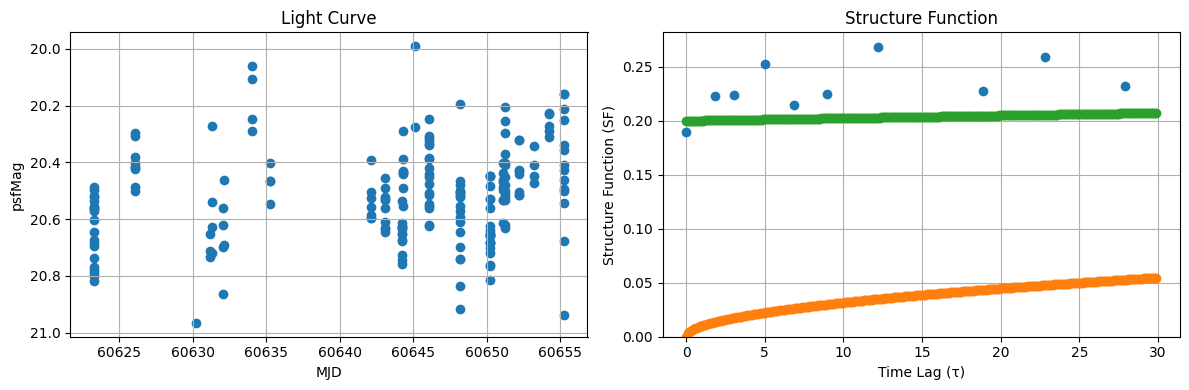

In [114]:

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Left: lightcurve
axs[0].scatter(row_r_clean['midpointMjdTai'].values, row_r_clean['psfMag'].values)
axs[0].set_xlabel("MJD")
axs[0].set_ylabel("psfMag")
axs[0].invert_yaxis()
axs[0].grid(True)
axs[0].set_title("Light Curve")

# Right: structure function
axs[1].plot(tau, SF, 'o')
axs[1].plot(np.arange(0,30,0.1), 0.1 * np.sqrt(np.arange(0,30,0.1)/100), 'o')
axs[1].plot(np.arange(0,30,0.1), np.sqrt( 0.2**2 +  (0.1 * np.sqrt(np.arange(0,30,0.1)/100))**2), 'o')
axs[1].set_ylim(bottom=0)
axs[1].set_xlabel("Time Lag (τ)")
axs[1].set_ylabel("Structure Function (SF)")
axs[1].grid(True)
axs[1].set_title("Structure Function")

plt.tight_layout()
plt.show()

In [ ]:
SF = 0.1 * np.sqrt(t)

In [105]:
row_r_clean['psfMagErr'].values

array([0.00266198, 0.00269968, 0.00264041, 0.00257102, 0.00268102,
       0.00250809, 0.00253945, 0.00260293, 0.00261017, 0.0026141 ,
       0.00252914, 0.00255412, 0.00246062, 0.00240739, 0.00253002,
       0.00250379, 0.00245178, 0.00250798, 0.00246914, 0.00246381,
       0.00244436, 0.00246656, 0.00300091, 0.0030526 , 0.00305474,
       0.00306578, 0.00295065, 0.00305656, 0.00303801, 0.00296322,
       0.00391854, 0.00337458, 0.00330136, 0.00331185, 0.00354865,
       0.00364757, 0.00357922, 0.00363731, 0.0026378 , 0.00264188,
       0.0027449 , 0.00282096, 0.00278434, 0.00273735, 0.00239676,
       0.00229551, 0.00232732, 0.00224723, 0.00233609, 0.00260593,
       0.00270784, 0.00258165, 0.00260532, 0.00240668, 0.00244094,
       0.00248314, 0.00235042, 0.00240941, 0.00250717, 0.0024916 ,
       0.00254645, 0.0025016 , 0.00255137, 0.00256579, 0.00247038,
       0.00252733, 0.00254772, 0.0024803 , 0.00253839, 0.00242225,
       0.00246433, 0.00248875, 0.00241781, 0.00246342, 0.00240